# Cryto price forecasting using Autoformer 

In [1]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
from transformers import AutoModel, AutoTokenizer 
from datetime import datetime
import ta
from sklearn.model_selection import train_test_split




c:\Users\ivoto\AppData\Local\Programs\Python\Python312\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Obtener el dataset
data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.drop(['Adj Close', 'Open', 'High', 'Low'], axis=1, inplace=True)
data


,Close,Volume
Date,,
2020-01-01,7200.174316,1.856566e+10
2020-01-02,6985.470215,2.080208e+10
2020-01-03,7344.884277,2.811148e+10
2020-01-04,7410.656738,1.844427e+10
2020-01-05,7411.317383,1.972507e+10
...,...,...
2024-04-19,63843.570313,4.992043e+10
2024-04-20,64994.441406,2.309749e+10
2024-04-21,64926.644531,2.050664e+10


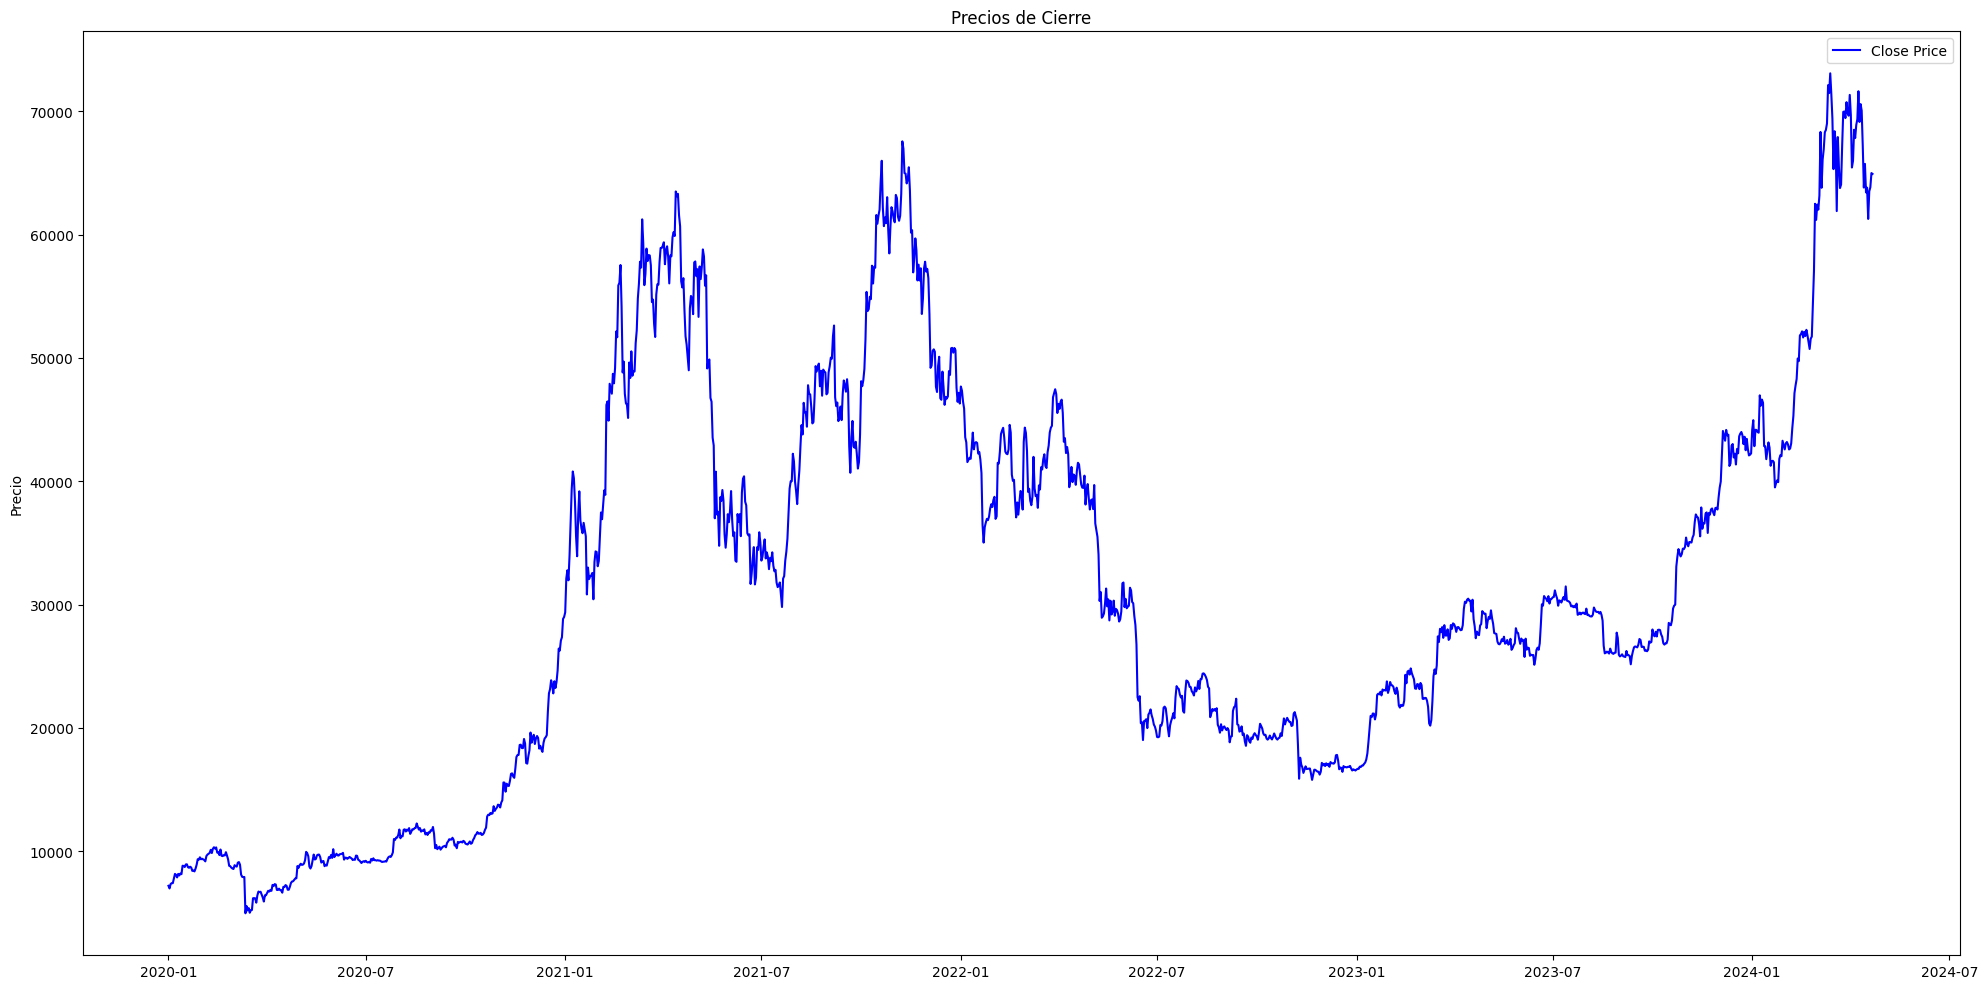

In [3]:
# Visualizacion
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 1, 1)  # Para precios y medias móviles
ax1.plot(data.index, data['Close'], label='Close Price', color='blue')

ax1.set_title('Precios de Cierre')
ax1.set_ylabel('Precio')
ax1.legend()
plt.tight_layout()
plt.show()


## Calculamos Indicadores

In [4]:
# Calcular indicadores
# Añadir medias móviles
data['sma'] = ta.trend.sma_indicator(data['Close'], window=30)
data['ema20'] = ta.trend.ema_indicator(data['Close'], window=20)
data['ema50'] = ta.trend.ema_indicator(data['Close'], window=50)
data['ema200'] = ta.trend.ema_indicator(data['Close'], window=200)


# Añadir RSI
data['rsi'] = ta.momentum.rsi(data['Close'], window=14)

# Añadir MACD
macd = ta.trend.MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()

# # Añadir Bandas de Bollinger
# bollinger = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
# data['bollinger_hband'] = bollinger.bollinger_hband()
# data['bollinger_lband'] = bollinger.bollinger_lband()
# data['bollinger_mavg'] = bollinger.bollinger_mavg()

# Ver los datos con indicadores añadidos
print(data[['Close', 'sma', 'ema20', 'ema50', 'ema200', 'rsi', 'macd', 'macd_signal']].head())

                  Close  sma  ema20  ema50  ema200  rsi  macd  macd_signal
Date                                                                      
2020-01-01  7200.174316  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2020-01-02  6985.470215  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2020-01-03  7344.884277  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2020-01-04  7410.656738  NaN    NaN    NaN     NaN  NaN   NaN          NaN
2020-01-05  7411.317383  NaN    NaN    NaN     NaN  NaN   NaN          NaN


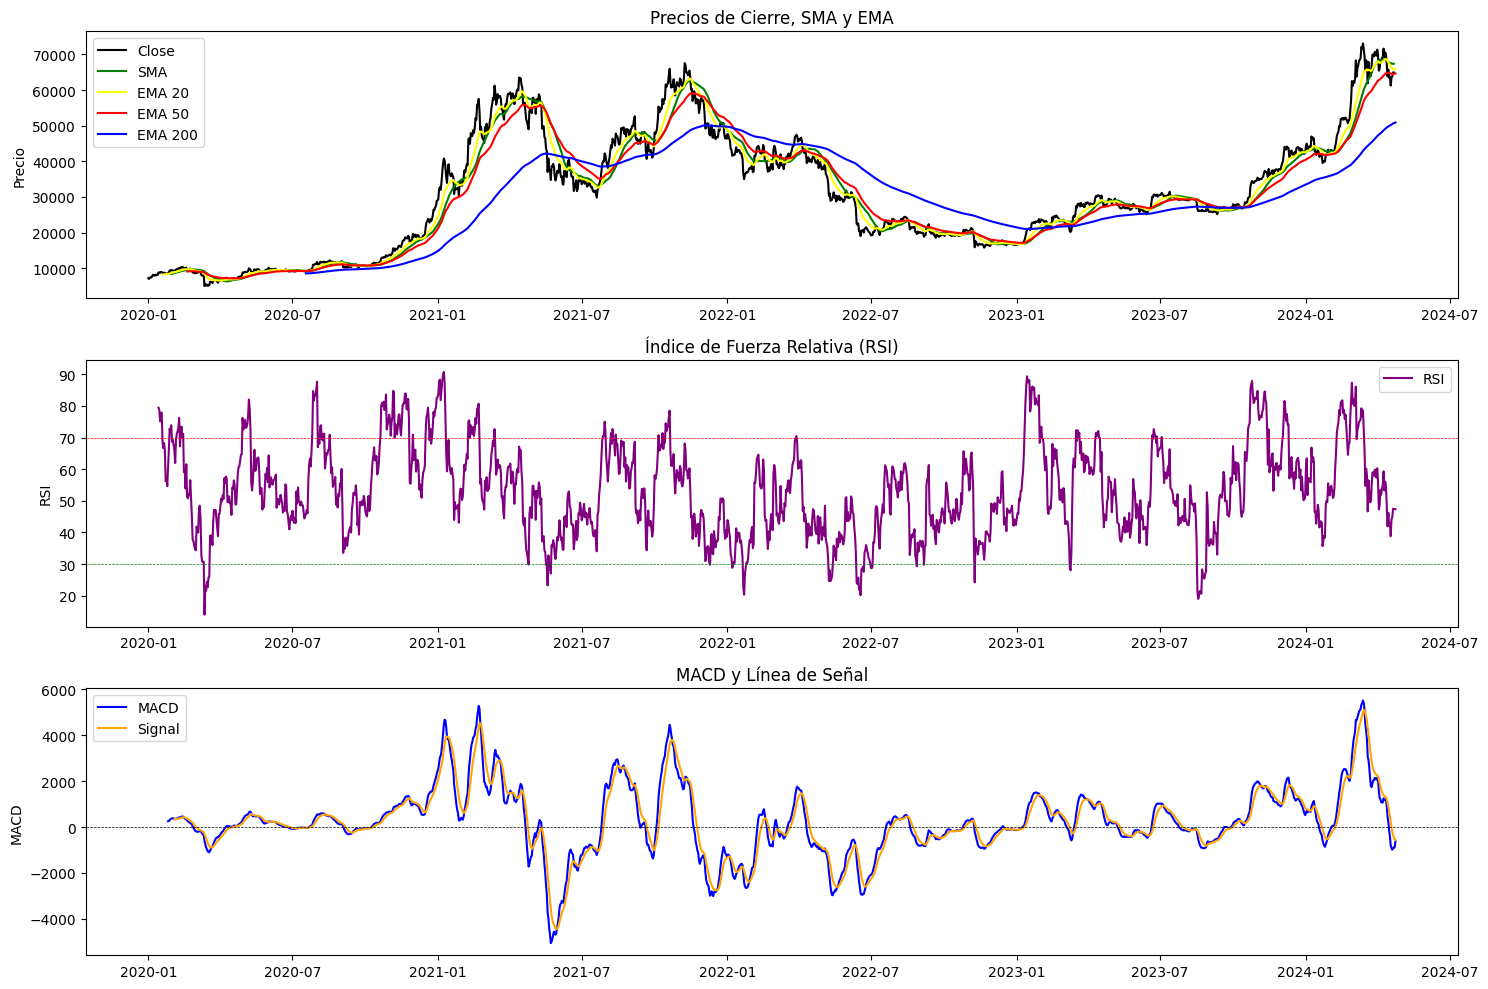

In [5]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 10))
# Crear subplots
ax1 = plt.subplot(3, 1, 1)  # Para precios y medias móviles
ax2 = plt.subplot(3, 1, 2, sharex=ax1)  # Para RSI
ax3 = plt.subplot(3, 1, 3, sharex=ax1)  # Para MACD
# Gráfico de precios, SMA y EMA
ax1.plot(data.index, data['Close'], label='Close', color='black')
ax1.plot(data.index, data['sma'], label='SMA', color='green')
ax1.plot(data.index, data['ema20'], label='EMA 20', color='yellow')
ax1.plot(data.index, data['ema50'], label='EMA 50', color='red')
ax1.plot(data.index, data['ema200'], label='EMA 200', color='blue')
ax1.set_title('Precios de Cierre, SMA y EMA')
ax1.set_ylabel('Precio')
ax1.legend()

# Gráfico de RSI
ax2.plot(data.index, data['rsi'], label='RSI', color='purple')
ax2.axhline(70, linestyle='--', color='red', linewidth=0.5)
ax2.axhline(30, linestyle='--', color='green', linewidth=0.5)
ax2.set_title('Índice de Fuerza Relativa (RSI)')
ax2.set_ylabel('RSI')
ax2.legend()

# Gráfico de MACD
ax3.plot(data.index, data['macd'], label='MACD', color='blue')
ax3.plot(data.index, data['macd_signal'], label='Signal', color='orange')
ax3.axhline(0, linestyle='--', color='black', linewidth=0.5)
ax3.set_title('MACD y Línea de Señal')
ax3.set_ylabel('MACD')
ax3.legend()

# Ajustar el layout y mostrar los gráficos
plt.tight_layout()
plt.show()

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [7]:
data1 = data.dropna()
data1

,Close,Volume,sma,ema20,ema50,ema200,rsi,macd,macd_signal
Date,,,,,,,,,
2020-07-18,9159.040039,1.225260e+10,9245.300977,9231.180849,9213.858133,8546.818671,45.716689,-38.296540,-34.040731
2020-07-19,9185.817383,1.293900e+10,9241.894271,9226.860519,9212.758496,8553.176867,47.091899,-37.173502,-34.667285
2020-07-20,9164.231445,1.375560e+10,9236.290625,9220.895845,9210.855474,8559.257012,46.078480,-37.591954,-35.252219
2020-07-21,9374.887695,1.806958e+10,9238.665885,9235.561736,9217.288110,8567.372740,56.024356,-20.686916,-32.339158
2020-07-22,9525.363281,1.653225e+10,9234.554069,9263.161883,9229.369490,8576.904984,61.488782,4.797271,-24.911873
...,...,...,...,...,...,...,...,...,...
2024-04-17,61276.691406,4.191525e+10,67461.216016,66584.149096,64608.905851,50200.847537,38.816389,-800.914302,217.331381
2024-04-18,63512.753906,3.600631e+10,67514.548698,66291.635268,64565.919500,50333.304317,44.081793,-925.197970,-11.174489
2024-04-19,63843.570313,4.992043e+10,67378.878646,66058.486225,64537.592081,50467.734825,44.838143,-985.637734,-206.067138


In [8]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data1, lookback)
shifted_df

,Close,Volume,sma,ema20,ema50,ema200,rsi,macd,macd_signal,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,,,,,,,,,
2020-07-25,9677.113281,1.661007e+10,9254.120605,9350.957318,9271.246598,8607.103263,65.432086,66.987114,11.474648,9536.892578,9581.072266,9525.363281,9374.887695,9164.231445,9185.817383,9159.040039
2020-07-26,9905.166992,2.050800e+10,9278.862240,9403.739192,9296.106221,8620.019320,71.309597,102.129464,29.605611,9677.113281,9536.892578,9581.072266,9525.363281,9374.887695,9164.231445,9185.817383
2020-07-27,10990.873047,3.535975e+10,9343.711654,9554.894797,9362.567666,8643.609905,84.671687,215.107806,66.706050,9905.166992,9677.113281,9536.892578,9581.072266,9525.363281,9374.887695,9164.231445
2020-07-28,10912.823242,2.876655e+10,9402.686361,9684.221316,9423.362002,8666.189142,81.724981,294.946034,112.354047,10990.873047,9905.166992,9677.113281,9536.892578,9581.072266,9525.363281,9374.887695
2020-07-29,11100.467773,2.461725e+10,9466.340137,9819.101931,9489.130856,8690.410820,83.235538,369.104939,163.704225,10912.823242,10990.873047,9905.166992,9677.113281,9536.892578,9581.072266,9525.363281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17,61276.691406,4.191525e+10,67461.216016,66584.149096,64608.905851,50200.847537,38.816389,-800.914302,217.331381,63811.863281,63426.210938,65738.726563,63821.472656,67195.867188,70060.609375,70587.882813
2024-04-18,63512.753906,3.600631e+10,67514.548698,66291.635268,64565.919500,50333.304317,44.081793,-925.197970,-11.174489,61276.691406,63811.863281,63426.210938,65738.726563,63821.472656,67195.867188,70060.609375
2024-04-19,63843.570313,4.992043e+10,67378.878646,66058.486225,64537.592081,50467.734825,44.838143,-985.637734,-206.067138,63512.753906,61276.691406,63811.863281,63426.210938,65738.726563,63821.472656,67195.867188


## Normalizamos el DataSet 

In [9]:
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(shifted_df)
data_scaled

array([[-1.        , -0.93473554, -1.        , ..., -1.        ,
        -0.99932459, -1.        ],
       [-0.9928066 , -0.91218049, -0.99916556, ..., -0.99340868,
        -1.        , -0.99916222],
       [-0.95856065, -0.826242  , -0.99697844, ..., -0.98870038,
        -0.99340868, -0.99983758],
       ...,
       [ 0.70854893, -0.74198779,  0.96032213, ...,  0.77018594,
         0.71019608,  0.81579405],
       [ 0.74485035, -0.89719663,  0.95976346, ...,  0.69782855,
         0.77018594,  0.71021961],
       [ 0.74271187, -0.91218832,  0.96105392, ...,  0.70989541,
         0.69782855,  0.7702046 ]])

## Dividimos en conjunto de Entrenamiento y Test

In [10]:
X = data_scaled[:, 1:]
y = data_scaled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1093, 15), (274, 15), (1093,), (274,))

## Convertimos a Tensor

In [11]:
X_train = X_train.reshape((-1, 15, 1))
X_test = X_test.reshape((-1, 15, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1093, 15, 1), (274, 15, 1), (1093, 1), (274, 1))

In [12]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1093, 15, 1]),
 torch.Size([274, 15, 1]),
 torch.Size([1093, 1]),
 torch.Size([274, 1]))

In [13]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [14]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 15, 1]) torch.Size([16, 1])


In [16]:
import torch
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [18]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [19]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.184
***************************************************

Epoch: 2

Val Loss: 0.152
***************************************************

Epoch: 3

Val Loss: 0.094
***************************************************

Epoch: 4

Val Loss: 0.049
***************************************************

Epoch: 5

Val Loss: 0.042
***************************************************

Epoch: 6

Val Loss: 0.037
***************************************************

Epoch: 7

Val Loss: 0.031
***************************************************

Epoch: 8

Val Loss: 0.025
***************************************************

Epoch: 9

Val Loss: 0.020
***************************************************

Epoch: 10

Val Loss: 0.017
***************************************************

Epoch: 11

Val Loss: 0.015
***************************************************

Epoch: 12

Val Loss: 0.014
***************************************************

Epoch: 13

Val Loss: 0.013
**********************

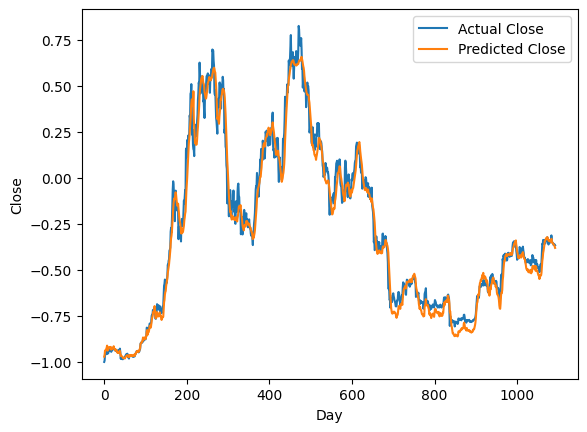

In [20]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

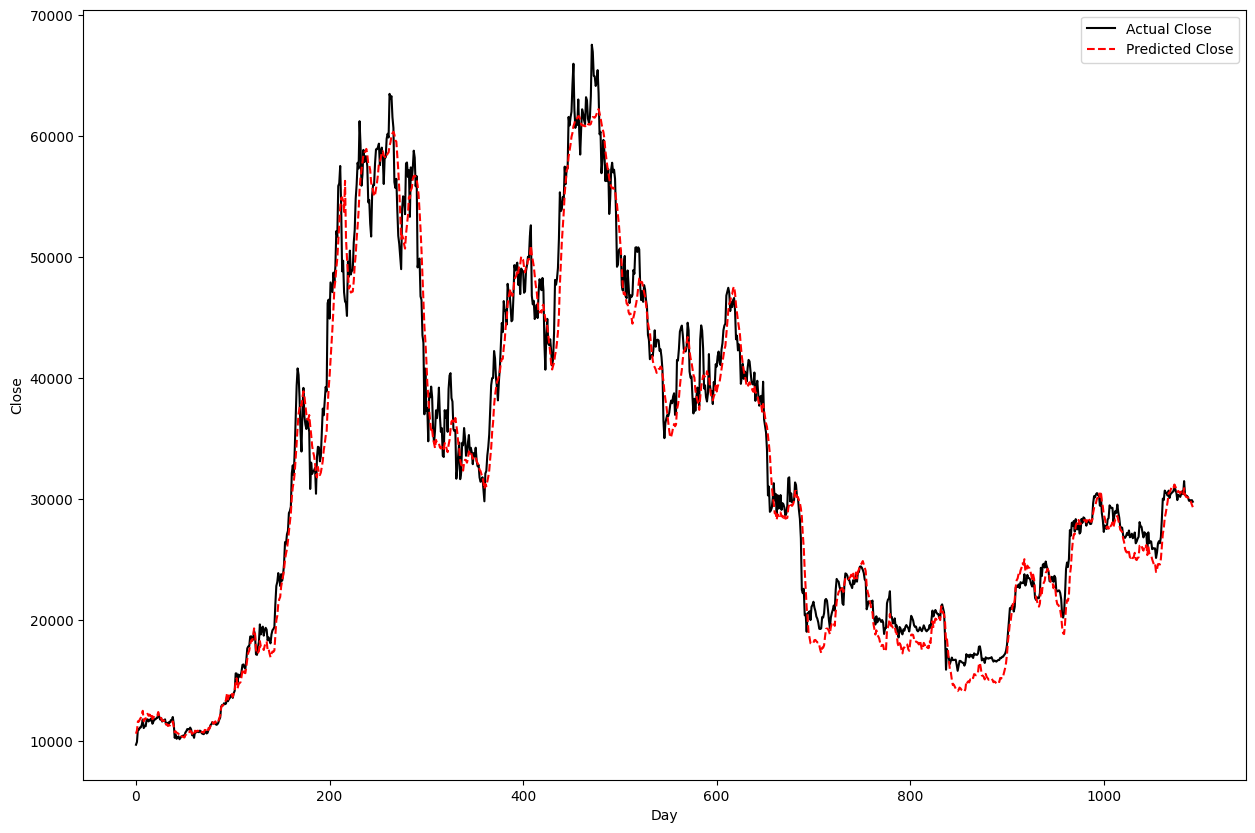

In [50]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 15+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions
dummies = np.zeros((X_train.shape[0], 15+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

plt.figure(figsize=(15, 10))

plt.plot(new_y_train, label='Actual Close', color='black')
plt.plot(train_predictions, label='Predicted Close', color='red', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


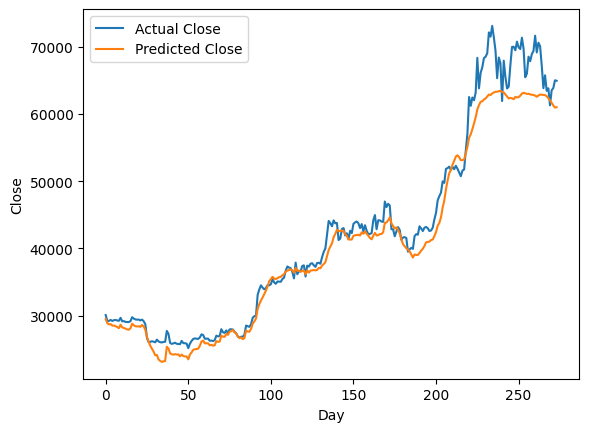

In [22]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 15+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions
dummies = np.zeros((X_test.shape[0], 15+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


Mean Squared Error (MSE): 8215865.17642952
Root Mean Squared Error (RMSE): 2866.33305399591
Mean Absolute Error (MAE): 2015.152067428175
R² Score: 0.9607833689212275


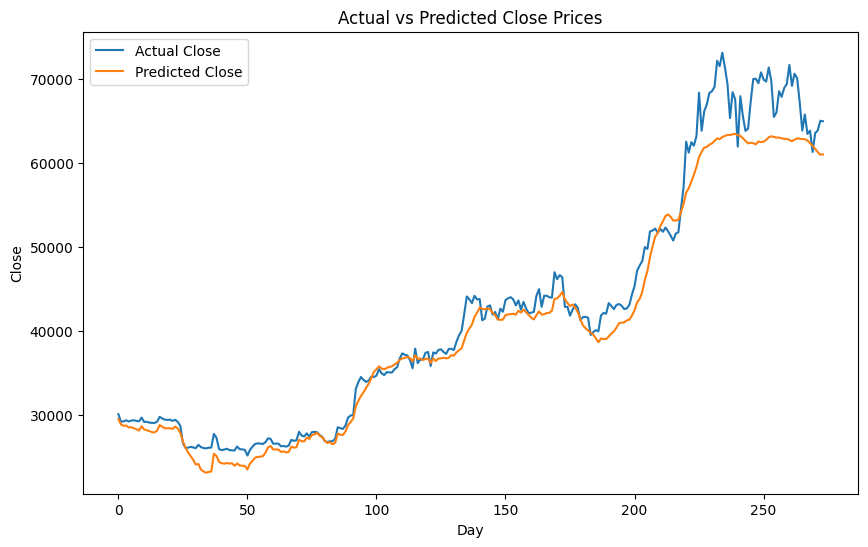

In [32]:
# Obtener las predicciones del modelo
model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred_batch = model(X_batch)
        y_pred.append(y_pred_batch.cpu().numpy())

y_pred = np.concatenate(y_pred).flatten()

# Crear una matriz dummy con las dimensiones correctas
num_features = data_scaled.shape[1]  # Asegurarse de que coincida con las características originales
dummies_pred = np.zeros((len(y_pred), num_features))
dummies_test = np.zeros((len(y_test), num_features))

# Insertar las predicciones y los valores reales en la primera columna
dummies_pred[:, 0] = y_pred
dummies_test[:, 0] = y_test.cpu().numpy().flatten()

# Inversión de la escala de las predicciones
y_pred_inversed = scaler.inverse_transform(dummies_pred)[:, 0]

# Inversión de la escala de los valores reales
y_test_inversed = scaler.inverse_transform(dummies_test)[:, 0]

# Calcular las métricas de evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test_inversed, y_pred_inversed)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inversed, y_pred_inversed)
r2 = r2_score(y_test_inversed, y_pred_inversed)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test_inversed, label='Actual Close')
plt.plot(y_pred_inversed, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.show()


In [26]:
# Obtener las predicciones del modelo
model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred_batch = model(X_batch)
        y_pred.append(y_pred_batch.cpu().numpy())

y_pred = np.concatenate(y_pred).flatten()

# Crear una matriz dummy con las dimensiones correctas
# Aquí data_scaled.shape[1] debe ser el número de características originales
num_features = data_scaled.shape[1]
dummies_pred = np.zeros((len(y_pred), num_features))
dummies_test = np.zeros((len(y_test), num_features))

# Insertar las predicciones y los valores reales en la primera columna
dummies_pred[:, 0] = y_pred
dummies_test[:, 0] = y_test.cpu().numpy().flatten()

# Inversión de la escala de las predicciones
y_pred_inversed = scaler.inverse_transform(dummies_pred)[:, 0]

# Inversión de la escala de los valores reales
y_test_inversed = scaler.inverse_transform(dummies_test)[:, 0]


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_inversed, y_pred_inversed)
mae = mean_absolute_error(y_test_inversed, y_pred_inversed)
r2 = r2_score(y_test_inversed, y_pred_inversed)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')


Mean Squared Error (MSE): 8215865.17642952
Mean Absolute Error (MAE): 2015.152067428175
R² Score: 0.9607833689212275


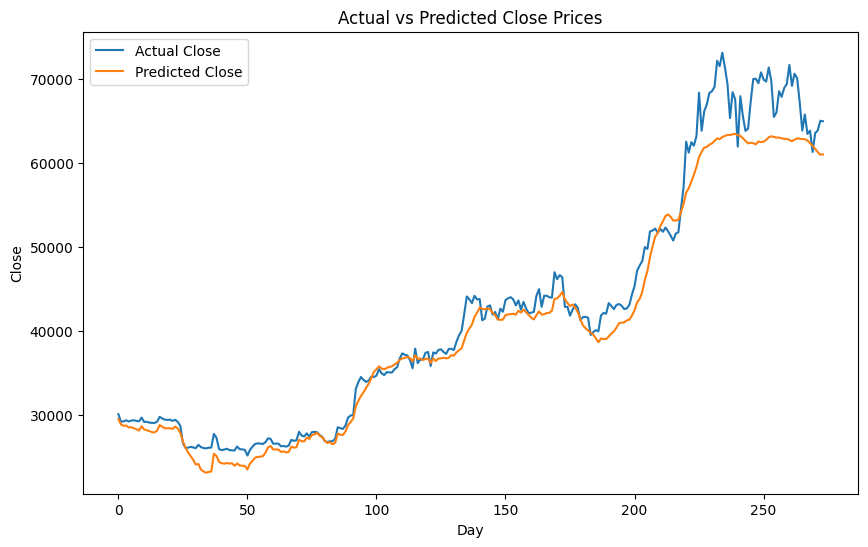

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inversed, label='Actual Close')
plt.plot(y_pred_inversed, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.show()


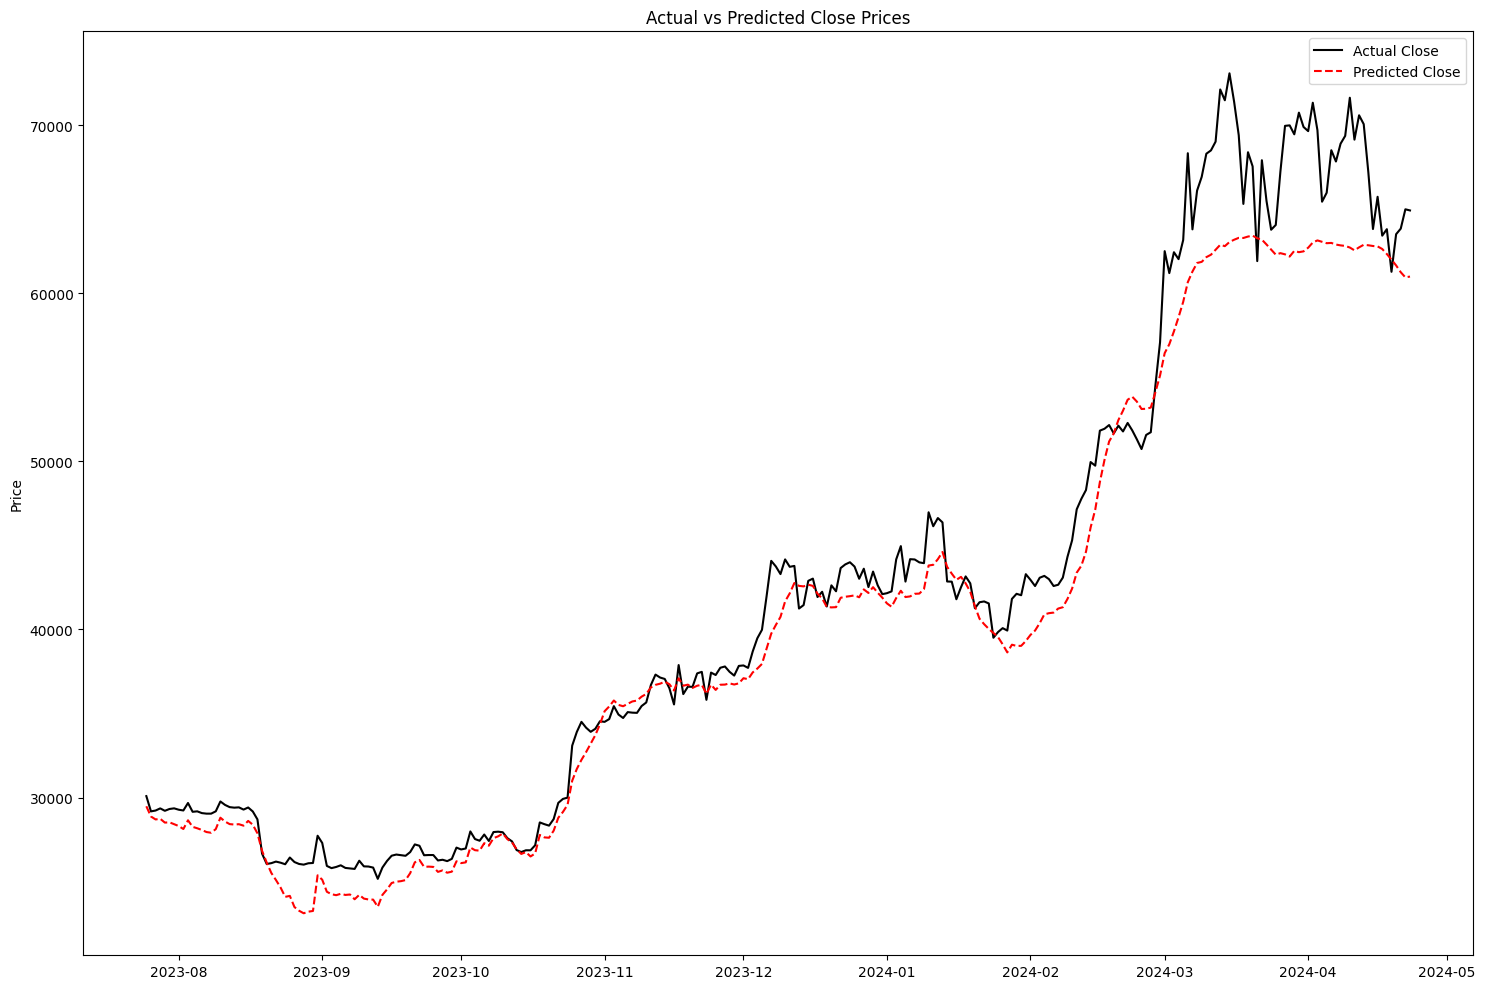

In [51]:
import matplotlib.pyplot as plt

# Supongamos que ya tienes `data` que incluye los indicadores técnicos y el índice adecuado.
# `y_test_inversed` y `y_pred_inversed` contienen los valores reales y predichos de los precios de cierre.

# Crear un DataFrame temporal para los datos predichos y reales
result_df = pd.DataFrame({
    'Actual Close': y_test_inversed,
    'Predicted Close': y_pred_inversed,
    'Date': data.index[-len(y_test_inversed):]
}).set_index('Date')

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 10))

# Crear el subplot para precios reales y predichos
ax1 = plt.subplot(1, 1, 1)  # Para precios reales y predichos

# Gráfico de precios reales y predichos
ax1.plot(result_df.index, result_df['Actual Close'], label='Actual Close', color='black')
ax1.plot(result_df.index, result_df['Predicted Close'], label='Predicted Close', color='red', linestyle='--')
ax1.set_title('Actual vs Predicted Close Prices')
ax1.set_ylabel('Price')
ax1.legend()

# Ajustar el layout y mostrar los gráficos
plt.tight_layout()
plt.show()

